# Exercise 10
Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# load the data into our training and test sets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# images are 28 x 28

#split our data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full/255., y_train_full, test_size=10000, random_state=42)
X_test = X_test / 255.

In [2]:
y_train

array([8, 5, 1, ..., 0, 0, 4], dtype=uint8)

In [3]:
# trying to find the optimal learning rate
K = keras.backend

# create a class for the exponential learning rate
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
# end of class definition and implementatons

In [4]:
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = keras.models.Sequential()
# our input layer
input_layer = keras.layers.Flatten(input_shape=[28, 28])
# create a shallow 2 hidden layer network
layer1 = keras.layers.Dense(300, activation="relu")
# layer 2
layer2 = keras.layers.Dense(100, activation="relu")
# output layer with softmax activation function
main_output = keras.layers.Dense(10, activation="softmax")

# add our layers to our model
model.add(input_layer)
model.add(layer1)
model.add(layer2)
model.add(main_output)

# compile our model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3), # manually set the lr
              metrics=["accuracy"])
# create exponential learning rate object
expon_lr = ExponentialLearningRate(factor=1.005)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fit the model
history = model.fit(X_train, y_train, epochs=1, 
                    validation_data=(X_valid, y_valid),
                   callbacks=[expon_lr])

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 4s 89us/sample - loss: nan - accuracy: 0.6602 - val_loss: nan - val_accuracy: 0.0984


<Figure size 720x720 with 0 Axes>

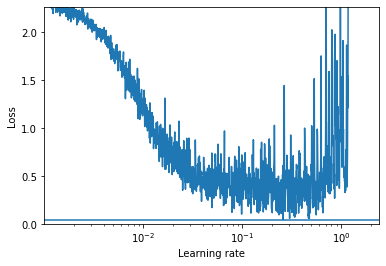

<Figure size 720x720 with 0 Axes>

In [12]:
plt.plot(expon_lr.rates, expon_lr.losses)
# gca() means get current axes
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [9]:
# playing with the history object
history.params

{'batch_size': 32,
 'epochs': 1,
 'steps': 1563,
 'samples': 50000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [18]:
# reset model training
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# recreate our model with our new learning rate
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [20]:
import os

run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index)) # save to current directory
run_logdir

'.\\my_mnist_logs\\run_001'

In [21]:
# implementing early stopping, checkpoint, and tensorboard callbacks
early_stopping_callback = keras.callbacks.EarlyStopping(patience=20)
checkpoint_callback = keras.callbacks.ModelCheckpoint("my_mnists_model.h5",
                                                     save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs = 100, 
                   validation_data = (X_valid,y_valid),
                   callbacks=[early_stopping_callback, checkpoint_callback,
                             tensorboard_cb])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 82us/sample - loss: 0.2439 - accuracy: 0.9255 - val_loss: 0.1258 - val_accuracy: 0.9622
Epoch 2/100
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0986 - accuracy: 0.9697 - val_loss: 0.0945 - val_accuracy: 0.9719
Epoch 3/100
50000/50000 [==============================] - 4s 72us/sample - loss: 0.0657 - accuracy: 0.9788 - val_loss: 0.0811 - val_accuracy: 0.9747
Epoch 4/100
50000/50000 [==============================] - 4s 73us/sample - loss: 0.0481 - accuracy: 0.9838 - val_loss: 0.0754 - val_accuracy: 0.9786
Epoch 5/100
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0334 - accuracy: 0.9895 - val_loss: 0.0815 - val_accuracy: 0.9781
Epoch 6/100
50000/50000 [==============================] - 4s 70us/sample - loss: 0.0271 - accuracy: 0.9917 - val_loss: 0.1496 - val_accuracy: 0.9606
Epoch 7/100
50000/50000 [=========================

In [4]:
model = keras.models.load_model("my_mnists_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 50us/sample - loss: 0.0753 - accuracy: 0.9807


[0.07526118362457274, 0.9807]

In [5]:
%tensorboard --logdir=./my_mnist_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


# EXTRA STUFF

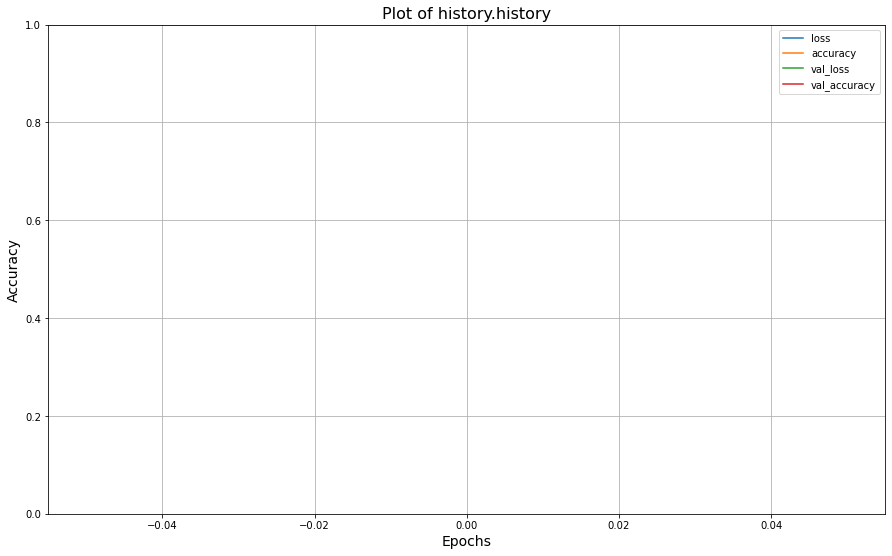

In [10]:
# plot out all of the keys

pd.DataFrame(history.history).plot(figsize=(15,9))
plt.grid()
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.title("Plot of history.history", fontsize=16)
plt.show()